In [1]:
import torch
from torch import nn
import numpy as np
import pickle
import matplotlib.pyplot as plt

CUDA = False

In [2]:
def test_error(model, x_test, y_test):
    model.eval()
    y_predicted = model(x_test)
    loss = (y_predicted - y_test).norm()
    
    y_predicted[y_predicted <= 0] = -1 
    y_predicted[y_predicted > 0] = 1 
    err_rate = 100.0 * (y_test != y_predicted).sum()/y_test.size(0)
    
    return err_rate, loss.item()

def batchify(x, y, batch_size=500):
    samples_num = x.size(0)
    perm = np.random.permutation(samples_num)
    x = x[perm]
    y = y[perm]
    
    start = 0
    end = batch_size if samples_num >= batch_size else samples_num
    while start < samples_num:
        yield x[start:end], y[start:end]

        start = end
        end = start + batch_size
        if end > samples_num:
            end = samples_num


class Reversi_net(nn.Module):
    def __init__(self):
        super(Reversi_net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(128, 1200),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Linear(1200, 200),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.fc2 = nn.Linear(200, 1)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.fc2(out)
        return out
    
class Reversi_simple_heuristic_net(nn.Module):
    def __init__(self):
        super(Reversi_simple_heuristic_net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(3, 700),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Linear(700, 400),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.fc2 = nn.Linear(400, 1)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.fc2(out)
        return out
    
class Reversi_heuristic_net(nn.Module):
    def __init__(self):
        super(Reversi_heuristic_net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(5, 700),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Linear(700, 400),
            nn.Dropout(0.5),
            nn.ReLU()
            )
        self.fc2 = nn.Linear(400, 1)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.fc2(out)
        return out

    
def train(model, x, y, x_test, y_test, epoch_num=10, log_every=5):
    # Use the nn package to define our model and loss function.
    if CUDA:
        model.cuda()
    loss_fn = torch.nn.MSELoss(size_average=True)
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99997)
    
    history = {"train_losses":[], "train_errors":[], "test_errors":[], "test_losses":[]}
    iter_ = 0
    try:
        for t in range(epoch_num):
            model.train()
            for x_batch, y_batch in batchify(x, y, 200):
                
                if CUDA:
                    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
                
                scheduler.step()
                iter_ += 1

                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                y_pred[y_pred <= 0] = -1 
                y_pred[y_pred > 0] = 1 
                err_rate = 100.0 * (y_batch != y_pred).sum()/y_pred.size(0)

                history["train_losses"].append(loss.item()) 
                history["train_errors"].append(err_rate)

                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.10f} | err rate {2: >5.10f}%" \
                              .format(iter_, loss.item(), err_rate)
    
            test_err, test_loss = test_error(model, x_test, y_test)
            history["test_errors"].append( (iter_, test_err) )
            history["test_losses"].append( (iter_, test_loss) )
            print('After epoch {0}, test_err = {1}, test_loss = {2}'.format(t, test_err, test_loss))
            
    except KeyboardInterrupt:
        pass
        
        return history
    
def print_history(history):
    plt.figure(figsize=(16,10))
    plt.subplot(121)
    plt.plot(history['train_losses'], label='train loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history['train_errors'], label='train error')
    history['test_errors'] = np.array(history['test_errors'])
    plt.plot(history['test_errors'][:,0],history['test_errors'][:,1], label='test error')
    plt.legend()
    plt.show()

In [3]:
## Load Data
#dataset = open('reversi_learning_data/bigger.dat', 'r')
#dataset = open('reversi_learning_data/smaller.dat', 'r')
dataset = open('mine.dat', 'r')

#####
# Format danych:
# rezultat plansza przewaga_pionkow zajete_rogi zajete_pola_wokol_rogow mobilnosc  
#####


games_X, games_X_heurs, games_Y = [], [], []

for l in dataset:
    board = np.zeros((2,8,8)).astype(float)

    game = l.split(' ')

    min_pieces = [1 if p=='0' else 0 for p in game[1].rstrip()]
    max_pieces = [1 if p=='1' else 0 for p in game[1].rstrip()]

    board[0,:,:] = np.array(min_pieces).reshape(8,8).copy()
    board[1,:,:] = np.array(max_pieces).reshape(8,8).copy()
    board_heurs = np.array([float(val) for val in game[2:]])

    games_X_heurs.append(board_heurs)
    games_X.append(board)
    games_Y.append(int(game[0]))


games_X = np.array(games_X)
games_X_heurs = np.array(games_X_heurs)
games_Y = np.array(games_Y).reshape((-1, 1))
print(games_X_heurs.shape)

x = torch.from_numpy(games_X).float()
x_heurs = torch.from_numpy(games_X_heurs).float()
y = torch.from_numpy(games_Y).float()
del games_X
del games_Y
del games_X_heurs

# 97 % train, 3 % test
split_num = int(0.97*y.size(0))

x_test = x[split_num:]
x_heurs_test = x_heurs[split_num:]
y_test = y[split_num:]

if CUDA:
    x_test = x_test.cuda()
    x_heurs_test = x_heurs_test.cuda()
    y_test = y_test.cuda()

x = x[:split_num]
x_heurs = x_heurs[:split_num]
y = y[:split_num]

(2608581, 5)


NameError: name 'games_Y' is not defined

Minibatch     30  | loss 2.3910486698 | err rate 55.0000000000%
Minibatch     60  | loss 1.1189935207 | err rate 43.0000000000%
Minibatch     90  | loss 1.0211952925 | err rate 42.0000000000%
Minibatch    120  | loss 1.0148988962 | err rate 43.0000000000%
Minibatch    150  | loss 0.9561702013 | err rate 37.0000000000%
Minibatch    180  | loss 0.9294297695 | err rate 39.0000000000%
Minibatch    210  | loss 1.0088834763 | err rate 44.0000000000%
Minibatch    240  | loss 0.9335533381 | err rate 35.0000000000%
Minibatch    270  | loss 0.9011523724 | err rate 39.0000000000%
Minibatch    300  | loss 0.8444431424 | err rate 33.0000000000%
Minibatch    330  | loss 0.9279951453 | err rate 37.0000000000%
Minibatch    360  | loss 0.8881499767 | err rate 32.0000000000%
Minibatch    390  | loss 0.9834189415 | err rate 45.0000000000%
Minibatch    420  | loss 0.8800733685 | err rate 32.0000000000%
Minibatch    450  | loss 0.9188525677 | err rate 43.0000000000%
Minibatch    480  | loss 0.9162659645 | 

IndexError: too many indices for array

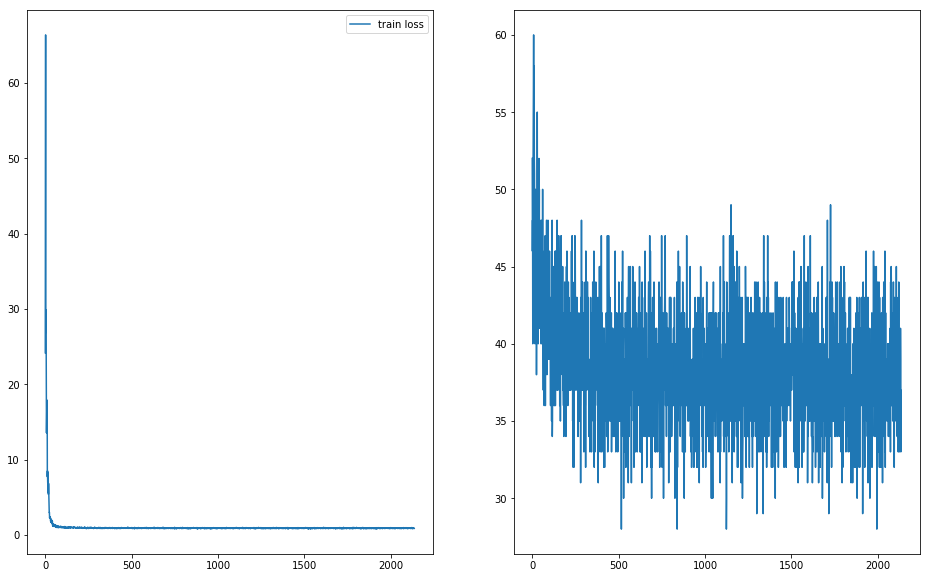

In [8]:
###
# parity and corners heuristics
###
model = Reversi_heuristic_net()
history = train(model, x_heurs, y, x_heurs_test, y_test, 500, log_every=30)
print_history(history)

torch.Size([2530323, 5])
torch.Size([78258, 5])
Minibatch     30  | loss 2.2619018555 | err rate 48.0000000000%
Minibatch     60  | loss 1.1158442497 | err rate 46.0000000000%
Minibatch     90  | loss 1.0644850731 | err rate 44.0000000000%
Minibatch    120  | loss 1.0370875597 | err rate 43.0000000000%
After epoch 0, test_err = 38, test_loss = 272.749694824
Minibatch    150  | loss 1.0078153610 | err rate 42.0000000000%
Minibatch    180  | loss 0.9915976524 | err rate 42.0000000000%
Minibatch    210  | loss 0.9854397178 | err rate 41.0000000000%
Minibatch    240  | loss 0.9769820571 | err rate 41.0000000000%
After epoch 1, test_err = 37, test_loss = 270.598846436
Minibatch    270  | loss 0.9667223692 | err rate 41.0000000000%
Minibatch    300  | loss 0.9621053934 | err rate 41.0000000000%
Minibatch    330  | loss 0.9516115189 | err rate 40.0000000000%
Minibatch    360  | loss 0.9478312731 | err rate 40.0000000000%
After epoch 2, test_err = 37, test_loss = 268.619293213
Minibatch    390

Minibatch   3210  | loss 0.8849060535 | err rate 37.0000000000%
Minibatch   3240  | loss 0.8790832162 | err rate 37.0000000000%
Minibatch   3270  | loss 0.8806597590 | err rate 37.0000000000%
Minibatch   3300  | loss 0.8814438581 | err rate 37.0000000000%
After epoch 25, test_err = 36, test_loss = 259.357818604
Minibatch   3330  | loss 0.8856852651 | err rate 37.0000000000%
Minibatch   3360  | loss 0.8828589916 | err rate 37.0000000000%
Minibatch   3390  | loss 0.8878435493 | err rate 38.0000000000%
Minibatch   3420  | loss 0.8840640783 | err rate 37.0000000000%
After epoch 26, test_err = 36, test_loss = 259.314025879
Minibatch   3450  | loss 0.8831543922 | err rate 37.0000000000%
Minibatch   3480  | loss 0.8834018707 | err rate 37.0000000000%
Minibatch   3510  | loss 0.8784944415 | err rate 37.0000000000%
Minibatch   3540  | loss 0.8787916899 | err rate 37.0000000000%
After epoch 27, test_err = 36, test_loss = 259.208831787
Minibatch   3570  | loss 0.8769080043 | err rate 37.000000000

Minibatch   6390  | loss 0.8719773293 | err rate 36.0000000000%
Minibatch   6420  | loss 0.8738411069 | err rate 37.0000000000%
Minibatch   6450  | loss 0.8800153136 | err rate 37.0000000000%
After epoch 50, test_err = 35, test_loss = 258.282043457
Minibatch   6480  | loss 0.8794016838 | err rate 37.0000000000%
Minibatch   6510  | loss 0.8754703403 | err rate 36.0000000000%
Minibatch   6540  | loss 0.8752205968 | err rate 36.0000000000%
Minibatch   6570  | loss 0.8721282482 | err rate 36.0000000000%
Minibatch   6600  | loss 0.8822481632 | err rate 37.0000000000%
After epoch 51, test_err = 35, test_loss = 258.669372559
Minibatch   6630  | loss 0.8831024170 | err rate 37.0000000000%
Minibatch   6660  | loss 0.8754575253 | err rate 36.0000000000%
Minibatch   6690  | loss 0.8761076331 | err rate 37.0000000000%
Minibatch   6720  | loss 0.8795595765 | err rate 37.0000000000%
After epoch 52, test_err = 35, test_loss = 259.054870605
Minibatch   6750  | loss 0.8720215559 | err rate 37.000000000

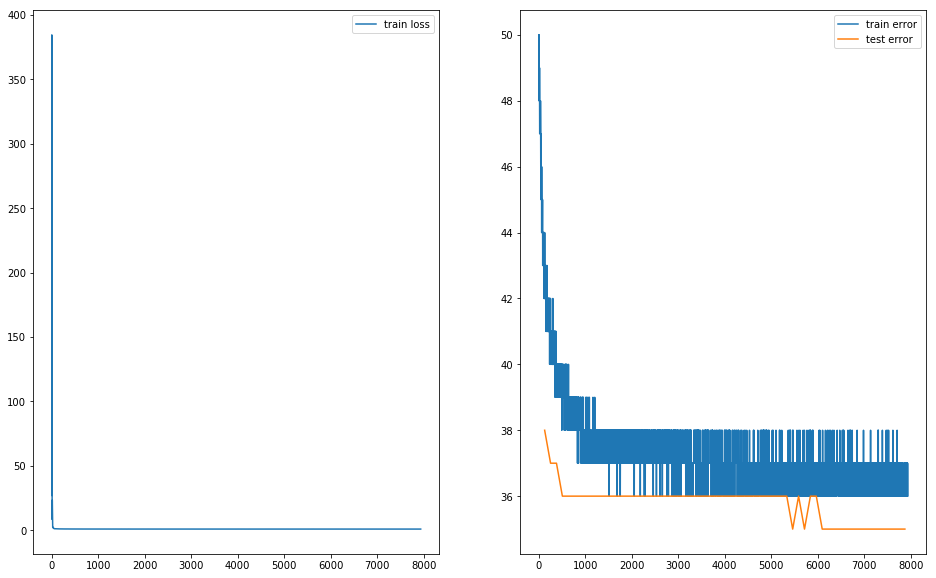

In [63]:
model = Reversi_heuristic_net()
history = train(model, x_info, y, x_info_test, y_test, 500, log_every=30)

print_history(history)
#torch.save(model.state_dict(), "heuristic_features")